In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

sklearn.set_config(display=”diagram”)

<font size=6>
    Sberbank Russian Housing Market
</font>

<hr style="border: solid rgb(0,0,0) 0.0px; background-color: rgb(0,0,0);height: 2.0px;"/>
<font color='red' size=5>
    The show so far ... 
</font>


**Summary**

1. Load data
2. Remove features
    * features missing more than 10%
    * features with high correlations to the other features
        * used hierarchical correlation dropper
3. Stage 1 transformations:
    * Ignored features: 
        * e.g. 'id' and 'datetime' columns
    * Scale num. features
        * perhaps better to wait until after 
            1. cat. encoding is done with ordinals
            2. imputation for (all) features
    * Cat. features
        * used Ordinal and OneHot-encoders
        * used custom encoder to include NANs
    * Retrieve column names        
    * Recast all features as needed
4. Stage 2 transformations:
    * Ignored features: 
        * e.g. 'id' and 'datetime' columns
    * Impute remaining features
        * Used `SimpleImputer`
        * `KNNImputer` failed
    * Retrieve column names
    * Recast all features as needed

5. Modeling

6. Evaluate errors

7. Feature importance

**TODOs**

0. Priorities
   1. $\checkmark$ ~~Remove the target feature for the pipeline?~~
        * if the pipeline is fit for the independent features, then it should work with them alone;
        * whatever preprocessing is needed for the target feature can be done independently, outside of the pipeline 
   
1. $\checkmark$ ~~Get the columns names of the transformed data after the `Pipeline` / `ColumnTransformer` steps~~
    * _Needed for checking, further exploration, and featuring engineering_
    
2. Check on the appropriate strategies
    * $\checkmark$ ~~first do cat. encoding with `ColumnTransformer`, then do scaling on numericals in another `Pipeline`~~
    * ~~do everything in a single `Pipeline` taking care of the steps~~ $\to$ everything done with `ColumnTransformer` instead
        * allows individual selection of features for transformations
    * ~~Drop features with many unfilled values (can't do _after_ imputing) or just impute?, then pipeline~~ 
        * $\checkmark$ ~~Drop features with many unfilled values before/after preprocessing?~~
        * $\checkmark$ ~~impute afterwards~~

3. $\checkmark$ ~~Drop features which are mutually correlated; keep only the most relevant ones~~
    * **!!!** do this before first preprocessing stage?

4. More EDA
    * Identify quantities to be removed:
        * $\checkmark$ ~~IDs which contribute to the spikes in the neg. tail of the 'price_doc' distribution~~ $\to$ _this led to a big step in improvement_
            * ~~or see if they're correlated with another feature, like 'sub_area'~~ $\to$ did not find this; just removed sampled IDs
            * **open** 
                * is it possible to automatically detect narrow-bin spikes in a distribution? and eleminate the rows which contribute to them?
        * $\checkmark$ ~~check the distribution of the 'sub_area' feature~~
            * ~~are there enough samples for each category?~~ 

5. More feature engineering
    * There are a few more things which can be done to see if there's an improvement:
        * $\checkmark$ ~~removing some IDs (rows) which have some outlier behavior (clearly defined spikes in distributions)~~
        * aggregating some features together (e.g. combining nearby 'sub_areas') $\to$ needs some ad hoc investigations
        * $\checkmark$ Using the classifiers to identify and reduce the number of features to only the important ones. $\to$ _no improvement; slightly worse with XGB_
            * $\checkmark$ removed the 'sub_area' feature entirely $\to$ _no improvement_
            * **TODO** try with other classifiers

6. Try to package up the routine into a single stage with a multistep pipeline
    * The issue is employing the KNN_imputer
        * the issue _was_ keeping track of the columns since the stages work on different subsets;
    * An idea would be to
        1. Order the columns first by datatype
        2. Then do the structure-preserving transformations (transformations which preserve the number of columns) like scaling, ordinal encoding, imputing(?))
        3. Then do the transformations like OneHotEnc 
    * **Notes**
        * since ther original plan was to use the KNN-imputer, where all features were needed together, this meant
            1. process the num. and cat. features separately
            2. re-attach columns and re-cast dtypes
            3. apply the KNN-imputer
    * **IDEA** to generalize, need a flexible pipeline 
        * `overall_pipeline([sub_pipeline1(data_subsetA, data_subsetB, data_subsetC), sub_pipeline2(data_subsetA, data_subset_rest),...])`
        * the problem is keeping track of the columns since after the first subpipeline, they will be lost.
            
**Notes**
* All transforms were included with `ColumnTransformer`
    * selects cols individually
    * can act as a pipeline
    * retrieve the columns names and ordering
        * _this is important to do the next steps of processing_

<hr style="border: solid rgb(0,0,0) 0.0px; background-color: rgb(0,0,0);height: 2.0px;"/>

In [2]:
# This will reload imports before executing code, allowing you to easily change contents of custom scripts
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [4]:
import os

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import random
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, 20)]
random.shuffle(colors)

In [6]:
#import importlib
import sys
sys.path.append('./helpers/')

<hr style="border: solid rgb(0,0,0) 0.0px; background-color: rgb(0,0,0);height: 4.0px;"/>

# Modeling

In [78]:
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn import metrics

## Load the data

In [7]:
df = pd.read_csv('../../datasets/sberbank-russian-housing-market/train_prepro.csv', \
                 infer_datetime_format=True, parse_dates=['timestamp'])

In [8]:
df.shape

(30471, 292)

In [87]:
X = df.drop(["id", "timestamp"], axis=1)
y = df[["price_doc_"]].copy()

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, test_size=0.25)

### Grid Search

In [88]:
#metric = 'neg_mean_squared_log_error'
metric = 'neg_mean_squared_error'

In [89]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_log_error, make_scorer
from sklearn.metrics.scorer import neg_mean_squared_error_scorer

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [104]:
model = xgb.XGBRegressor(objective="reg:squarederror",
                             colsample_bytree=0.46, gamma=0.047, 
                             learning_rate=0.04, max_depth=2, 
                             min_child_weight=0.5, n_estimators=2000,
                             reg_alpha=0.46, reg_lambda=0.86,
                             subsample=0.52, random_state=1, n_jobs=-1,silent=0)

param_grid = {
    'xgbregressor__max_depth' : [4, 8, 12, 16],
    'xgbregressor__estimators' : [400 ,800, 1600],
    "xgbregressor__learning_rate" : [0.02, 0.03, 0.04],
    "xgbregressor__min_child_weight" : [0.2, 0.3, 0.4, 0.5]
    }

search = GridSearchCV(model, param_grid, cv=3, scoring=metric, n_jobs=-1, verbose=10)
search.fit(X, y)
print(f"{search.best_params_}")
print(f"{np.sqrt(-search.best_score_):.4}")

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 25.0min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 30.3min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 38.3min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 43.9min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 54.4min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 62.5min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 73.2min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 81.4min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 94.6min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 105.4min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 1

{'xgbregressor__estimators': 400, 'xgbregressor__learning_rate': 0.02, 'xgbregressor__max_depth': 4, 'xgbregressor__min_child_weight': 0.2}
0.5883


In [111]:
#GridSearchCV XGBoost
"""
    n_estimators : int
        Number of gradient boosted trees.  Equivalent to number of boosting
        rounds.

    max_depth : int
        Maximum tree depth for base learners.
    learning_rate : float
        Boosting learning rate (xgb's "eta")
    objective : string or callable
        Specify the learning task and the corresponding learning objective or
        a custom objective function to be used (see note below).
    booster: string
        Specify which booster to use: gbtree, gblinear or dart.
    tree_method: --> documentation
    gamma : float
        Minimum loss reduction required to make a further partition on a leaf
        node of the tree.
    min_child_weight : int
        Minimum sum of instance weight(hessian) needed in a child.
    max_delta_step : int
        Maximum delta step we allow each tree's weight estimation to be.
    subsample : float
        Subsample ratio of the training instance.
    colsample_bytree : float
        Subsample ratio of columns when constructing each tree.
    colsample_bylevel : float
        Subsample ratio of columns for each level.
    colsample_bynode : float
        Subsample ratio of columns for each split.
    reg_alpha : float (xgb's alpha)
        L1 regularization term on weights
    reg_lambda : float (xgb's lambda)
        L2 regularization term on weights
    scale_pos_weight : float
        Balancing of positive and negative weights.
"""


xgbreg = xgb.XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7,
             eval_metric='rmse', gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints=None,
             max_delta_step=0, max_depth=10, min_child_weight=1,
             monotone_constraints=None, n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=0,
             subsample=0.7, tree_method=None, validate_parameters=False,
             verbosity=3)

param_grid = {
    'xgbregressor__max_depth' : [8, 12],
    'xgbregressor__estimators' : [100, 200],
    "xgbregressor__learning_rate" : [0.04, 0.06],
    "xgbregressor__min_child_weight" : [0.4, 1.2],
    }

search = GridSearchCV(xgbreg, param_grid, cv=3, scoring=metric, n_jobs=-1, verbose=20)
search.fit(X, y)
print(f"{search.best_params_}")
print(f"{np.sqrt(-search.best_score_):.4}")

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   51.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   51.9s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   52.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   52.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  3

[09:00:58] DEBUG: /workspace/src/gbm/gbtree.cc:146: Using tree method: 2
[09:00:59] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 616 extra nodes, 0 pruned nodes, max_depth=10
[09:00:59] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 640 extra nodes, 0 pruned nodes, max_depth=10
[09:01:00] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 988 extra nodes, 0 pruned nodes, max_depth=10
[09:01:00] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 910 extra nodes, 0 pruned nodes, max_depth=10
[09:01:01] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 920 extra nodes, 0 pruned nodes, max_depth=10
[09:01:01] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 698 extra nodes, 0 pruned nodes, max_depth=10
[09:01:02] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 808 extra nodes, 0 pruned nodes, max_depth=10
[09:01:02] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning en

[09:01:29] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 556 extra nodes, 0 pruned nodes, max_depth=10
[09:01:29] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 540 extra nodes, 0 pruned nodes, max_depth=10
[09:01:30] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 488 extra nodes, 0 pruned nodes, max_depth=10
[09:01:30] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 206 extra nodes, 0 pruned nodes, max_depth=10
[09:01:31] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 468 extra nodes, 0 pruned nodes, max_depth=10
[09:01:31] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 394 extra nodes, 0 pruned nodes, max_depth=10
[09:01:32] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 230 extra nodes, 0 pruned nodes, max_depth=10
[09:01:32] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 320 extra nodes, 0 pruned nodes, max_depth=10
[09:01:33] INFO: /worksp

In [115]:
"""
XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=0.7, eta=0.05,
             eval_metric='rmse', gamma=None, gpu_id=None,
             importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=10,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             objective='reg:squarederror', random_state=None, reg_alpha=None,
             reg_lambda=None, scale_pos_weight=None, silent=0, subsample=0.7,
             tree_method=None, validate_parameters=False, verbosity=None)
"""


xgb_params = {
    'eta': 0.05,
    'max_depth': 10,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    #'objective': 'reg:linear',
    # 'objective':'reg:squarederror', 'n_jobs':-1, #for the feature importance
    'eval_metric': 'rmse',
    'silent': 1
}

model = xgb.XGBRegressor(**xgb_params)

param_grid = {
    'xgbregressor__max_depth' : [8, 10, 12],
    "xgbregressor__learning_rate" : [0.04, 0.05, 0.06],
    }



kfold = KFold(n_splits=5, shuffle=True, random_state=1)
search = GridSearchCV(xgbreg, param_grid, cv=kfold, scoring=metric, n_jobs=-1, verbose=1)
search.fit(X, y)
print(f"{search.best_params_}")
print(f"{np.sqrt(-search.best_score_):.4}")

[09:28:27] ======== Monitor: Learner ========
[09:28:27] Configure: 0.001298s, 1 calls @ 1298us

[09:28:27] GetGradient: 0.136064s, 100 calls @ 136064us

[09:28:27] PredictRaw: 0.020187s, 100 calls @ 20187us

[09:28:27] UpdateOneIter: 44.8924s, 100 calls @ 44892383us

[09:28:27] ======== Monitor: GBTree ========
[09:28:27] BoostNewTrees: 42.6725s, 100 calls @ 42672518us

[09:28:27] CommitModel: 2.05905s, 100 calls @ 2059054us

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 12.8min finished


[09:41:17] DEBUG: /workspace/src/gbm/gbtree.cc:146: Using tree method: 2
[09:41:18] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 616 extra nodes, 0 pruned nodes, max_depth=10
[09:41:18] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 640 extra nodes, 0 pruned nodes, max_depth=10
[09:41:19] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 988 extra nodes, 0 pruned nodes, max_depth=10
[09:41:19] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 910 extra nodes, 0 pruned nodes, max_depth=10
[09:41:20] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 920 extra nodes, 0 pruned nodes, max_depth=10
[09:41:20] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 698 extra nodes, 0 pruned nodes, max_depth=10
[09:41:21] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 808 extra nodes, 0 pruned nodes, max_depth=10
[09:41:21] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning en

[09:41:49] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 556 extra nodes, 0 pruned nodes, max_depth=10
[09:41:49] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 540 extra nodes, 0 pruned nodes, max_depth=10
[09:41:50] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 488 extra nodes, 0 pruned nodes, max_depth=10
[09:41:50] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 206 extra nodes, 0 pruned nodes, max_depth=10
[09:41:51] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 468 extra nodes, 0 pruned nodes, max_depth=10
[09:41:51] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 394 extra nodes, 0 pruned nodes, max_depth=10
[09:41:52] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 230 extra nodes, 0 pruned nodes, max_depth=10
[09:41:52] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 320 extra nodes, 0 pruned nodes, max_depth=10
[09:41:52] INFO: /worksp

In [124]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 10,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    #'objective': 'reg:linear',
    # 'objective':'reg:squarederror', 'n_jobs':-1, #for the feature importance
    'eval_metric': 'rmse',
    'silent': 1
}

model = xgb.XGBRegressor(**xgb_params)
model.fit(X_train,y_train)
#predictions = model.predict(X_test)

kfold = KFold(n_splits=5, shuffle=True, random_state=1)
cvscorer = cross_val_score(model, X, y, cv=kfold, scoring=metric)

In [122]:
param_grid = {
    'xgbregressor__max_depth' : [8, 10, 12],
    "xgbregressor__eta" : [0.04, 0.05, 0.06],
    }


kfold = KFold(n_splits=5, shuffle=True, random_state=1)
search = GridSearchCV(model, param_grid, cv=kfold, scoring=metric, n_jobs=-1, verbose=0)
search.fit(X, y)
print(f"{search.best_params_}")
print(f"{np.sqrt(-search.best_score_):.4}")

{'xgbregressor__eta': 0.04, 'xgbregressor__max_depth': 8}
0.5278


In [134]:
for mdep in [6, 10, 14]:
    for eta in [0.03, 0.05, 0.07]:
        
        xgb_params = {
            'eta': eta,
            'max_depth': mdep,
            'subsample': 0.7,
            'colsample_bytree': 0.7,
            #'objective': 'reg:linear',
            # 'objective':'reg:squarederror', 'n_jobs':-1, #for the feature importance
            'eval_metric': 'rmse',
            'silent': 1
        }

        model = xgb.XGBRegressor(**xgb_params)
        #model.fit(X_train,y_train)
        #predictions = model.predict(X_test)

        kfold = KFold(n_splits=5, shuffle=True, random_state=1)
        cvscorer = cross_val_score(model, X, y, cv=kfold, scoring=metric)
        
        print(f"{mdep} and {eta} : {np.sqrt(-cvscorer)}")

6 and 0.03 : [0.56235599 0.55436795 0.54351341 0.55013458 0.49835918]
6 and 0.05 : [0.56025795 0.53895065 0.52990379 0.52790068 0.48509939]
6 and 0.07 : [0.5571593  0.53638571 0.51757359 0.52506484 0.48935352]
10 and 0.03 : [0.56045551 0.5589107  0.53130591 0.53865928 0.48276499]
10 and 0.05 : [0.55996603 0.5417227  0.51663691 0.52770425 0.49028224]
10 and 0.07 : [0.55871529 0.5388298  0.52046872 0.53124797 0.49394451]
14 and 0.03 : [0.56158605 0.56168899 0.53197282 0.5456208  0.4915766 ]
14 and 0.05 : [0.56352035 0.5566814  0.53096254 0.52834747 0.49521299]
14 and 0.07 : [0.56345494 0.55712817 0.52977254 0.53255232 0.49234366]


In [180]:
arr = np.array([])
n = 0
for mdep in [5, 6, 7]:
    for eta in [0.07, 0.09, 0.11]:
        
        xgb_params = {
            'eta': eta,
            'max_depth': mdep,
            'subsample': 0.7,
            'colsample_bytree': 0.7,
            #'objective': 'reg:linear',
            # 'objective':'reg:squarederror', 'n_jobs':-1, #for the feature importance
            'eval_metric': 'rmse',
            'silent': 1
        }

        model = xgb.XGBRegressor(**xgb_params)
        #model.fit(X_train,y_train)
        #predictions = model.predict(X_test)

        if n == 0:
            arr = np.sqrt(-cvscorer)
        else:
            arr = np.vstack([arr,np.sqrt(-cvscorer)])
        
        kfold = KFold(n_splits=5, shuffle=True, random_state=1)
        %time cvscorer = cross_val_score(model, X, y, cv=kfold, scoring=metric)
        
        print(f"{mdep} and {eta} : {np.sqrt(-cvscorer)}, mean = {np.sqrt(-cvscorer).mean()}")
        n+=1

CPU times: user 1min 32s, sys: 828 ms, total: 1min 33s
Wall time: 1min 33s
5 and 0.07 : [0.56077457 0.54279565 0.52164662 0.52769164 0.49337784], mean = 0.5292572627936253
CPU times: user 1min 31s, sys: 308 ms, total: 1min 31s
Wall time: 1min 31s
5 and 0.09 : [0.55977847 0.53876098 0.5257959  0.52049635 0.49507466], mean = 0.5279812717764996
CPU times: user 1min 31s, sys: 300 ms, total: 1min 31s
Wall time: 1min 31s
5 and 0.11 : [0.55819602 0.53601322 0.52710451 0.52647031 0.50345507], mean = 0.5302478258318272
CPU times: user 1min 50s, sys: 376 ms, total: 1min 50s
Wall time: 1min 50s
6 and 0.07 : [0.5571593  0.53638571 0.51757359 0.52506484 0.48935352], mean = 0.5251073912803484
CPU times: user 1min 49s, sys: 208 ms, total: 1min 49s
Wall time: 1min 49s
6 and 0.09 : [0.56368708 0.53838457 0.51736249 0.52136593 0.49657825], mean = 0.5274756642040774
CPU times: user 1min 49s, sys: 180 ms, total: 1min 49s
Wall time: 1min 49s
6 and 0.11 : [0.56305759 0.54143402 0.51949723 0.52445857 0.49756

In [197]:
xgb_params = {
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    #'objective': 'reg:linear',
    # 'objective':'reg:squarederror', 'n_jobs':-1, #for the feature importance
    'eval_metric': 'rmse',
    'silent': 1
}

model = xgb.XGBRegressor(**xgb_params)

param_grid = {
    "max_depth" : [5, 6, 7],
    "eta" : [0.07, 0.09, 0.11],
    }


kfold = KFold(n_splits=5, shuffle=True, random_state=1)
#cvscorer = cross_val_score(model, X, y, cv=kfold, scoring=metric, verbose=10)
search = GridSearchCV(model, param_grid, cv=kfold, scoring=metric, n_jobs=-1, verbose=10)
search.fit(X, y, verbose=False)

print(search.best_estimator_)
print(f"{search.best_params_}")
print(f"{np.sqrt(-search.best_score_):.4}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done  43 out of  45 | elapsed:  7.4min remaining:   20.5s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  7.7min finished


XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.07,
             eval_metric='rmse', gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints=None, learning_rate=0.0700000003,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=1,
             subsample=0.7, tree_method=None, validate_parameters=False,
             verbosity=None)
{'eta': 0.07, 'max_depth': 6}
0.5256


In [215]:
xgb_params = {
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    #'objective': 'reg:linear',
    # 'objective':'reg:squarederror', 'n_jobs':-1, #for the feature importance
    'eval_metric': 'rmse',
    'silent': 1
}

model = xgb.XGBRegressor(**xgb_params)

param_grid = {
    "max_depth" : [5, 6, 7],
    "eta" : [0.07, 0.09, 0.11],
    }


kfold = KFold(n_splits=3, shuffle=True, random_state=1)
#cvscorer = cross_val_score(model, X, y, cv=kfold, scoring=metric, verbose=10)
search = GridSearchCV(model, param_grid, cv=kfold, scoring=metric, n_jobs=-1, verbose=10)
search.fit(X, y, verbose=False)

print(search.best_estimator_)
print(f"{search.best_params_}")
print(f"{np.sqrt(-search.best_score_):.4}")

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  23 out of  27 | elapsed:  3.6min remaining:   37.2s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  4.0min finished


XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.09,
             eval_metric='rmse', gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints=None, learning_rate=0.0900000036,
             max_delta_step=0, max_depth=7, min_child_weight=1, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=1,
             subsample=0.7, tree_method=None, validate_parameters=False,
             verbosity=None)
{'eta': 0.09, 'max_depth': 7}
0.5288


In [198]:
xgb_params = {
    'eta': 0.07,
    'max_depth': 6,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    #'objective': 'reg:linear',
    # 'objective':'reg:squarederror', 'n_jobs':-1, #for the feature importance
    'eval_metric': 'rmse',
    'silent': 1
}

model = xgb.XGBRegressor(**xgb_params)
model.fit(X,y)
predictions = model.predict(X_test)
rmse = np.sqrt(metrics.mean_squared_error(y_test, predictions))
print("RMSE: %f" % (rmse))
# Need an offset since 
#   Mean Squared Logarithmic Error cannot be used when targets contain negative values.
offset = abs(min(y_test.price_doc_.min(), predictions.min()))
print(offset)
rmsle = np.sqrt(metrics.mean_squared_log_error(y_test+offset, predictions+offset))
print("RMSLE: %f" % (rmsle))

RMSE: 0.387120
1.4887433580256662
RMSLE: 0.156398


In [199]:
spredictions = search.predict(X_test)
rmse = np.sqrt(metrics.mean_squared_error(y_test, spredictions))
print("RMSE: %f" % (rmse))
# Need an offset since 
#   Mean Squared Logarithmic Error cannot be used when targets contain negative values.
offset = abs(min(y_test.price_doc_.min(), spredictions.min()))
print(offset)
rmsle = np.sqrt(metrics.mean_squared_log_error(y_test+offset, spredictions+offset))
print("RMSLE: %f" % (rmsle))

RMSE: 0.387120
1.4887433580256662
RMSLE: 0.156398


In [203]:
cval = cross_validate(model, X, y, cv=kfold, scoring=metric)

In [209]:
np.sqrt(-cval['test_score'])

array([0.5571593 , 0.53638571, 0.51757359, 0.52506484, 0.48935352])

In [ ]:
kpredictions = cval.predict(X_test)

In [ ]:
rmse = np.sqrt(metrics.mean_squared_error(y_test, kpredictions))
print("RMSE: %f" % (rmse))
# Need an offset since 
#   Mean Squared Logarithmic Error cannot be used when targets contain negative values.
offset = abs(min(y_test.price_doc_.min(), kpredictions.min()))
print(offset)
rmsle = np.sqrt(metrics.mean_squared_log_error(y_test+offset, kpredictions+offset))
print("RMSLE: %f" % (rmsle))

In [216]:
"""
    n_estimators : int
        Number of gradient boosted trees.  Equivalent to number of boosting
        rounds.

    max_depth : int
        Maximum tree depth for base learners.
    learning_rate : float
        Boosting learning rate (xgb's "eta")
    objective : string or callable
        Specify the learning task and the corresponding learning objective or
        a custom objective function to be used (see note below).
    booster: string
        Specify which booster to use: gbtree, gblinear or dart.
    tree_method: --> documentation
    gamma : float
        Minimum loss reduction required to make a further partition on a leaf
        node of the tree.
    min_child_weight : int
        Minimum sum of instance weight(hessian) needed in a child.
    max_delta_step : int
        Maximum delta step we allow each tree's weight estimation to be.
    subsample : float
        Subsample ratio of the training instance.
    colsample_bytree : float
        Subsample ratio of columns when constructing each tree.
    colsample_bylevel : float
        Subsample ratio of columns for each level.
    colsample_bynode : float
        Subsample ratio of columns for each split.
    reg_alpha : float (xgb's alpha)
        L1 regularization term on weights
    reg_lambda : float (xgb's lambda)
        L2 regularization term on weights
    scale_pos_weight : float
        Balancing of positive and negative weights.
"""

xgb_params = {
    'eta': 0.07,
    'max_depth': 6,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    #'objective': 'reg:linear',
    # 'objective':'reg:squarederror', 'n_jobs':-1, #for the feature importance
    'eval_metric': 'rmse',
    'silent': 1
}

model = xgb.XGBRegressor(**xgb_params)

param_grid = {
    'gamma': [ 0, 0.05],
    #'colsample_bytree' : [0.5, 0.7],
    'n_estimators' : [100, 200],
    "min_child_weight" : [0.4, 0.8, 1.2],
    }

kfold = KFold(n_splits=5, shuffle=True, random_state=1)
#cvscorer = cross_val_score(model, X, y, cv=kfold, scoring=metric, verbose=10)
search = GridSearchCV(model, param_grid, cv=kfold, scoring=metric, n_jobs=-1, verbose=10)
search.fit(X, y, verbose=False)

print(search.best_estimator_)
print(f"{search.best_params_}")
print(f"{np.sqrt(-search.best_score_):.4}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 16.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 16.3min finished


XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.07,
             eval_metric='rmse', gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints=None, learning_rate=0.0700000003,
             max_delta_step=0, max_depth=6, min_child_weight=1.2, missing=nan,
             monotone_constraints=None, n_estimators=200, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=1,
             subsample=0.7, tree_method=None, validate_parameters=False,
             verbosity=None)
{'gamma': 0, 'min_child_weight': 1.2, 'n_estimators': 200}
0.5201


In [217]:
search.cv_results_

{'mean_fit_time': array([42.5209558 , 81.46661668, 41.26491756, 81.95709095, 42.12452459,
        85.36955175, 45.8060183 , 88.68928571, 44.23607478, 81.87720037,
        43.4821445 , 77.28267612]),
 'std_fit_time': array([ 0.95192046,  1.07209948,  1.00026047,  1.26097011,  1.30195554,
         0.97427888,  0.83708302,  1.80287587,  1.51610339,  0.80857827,
         1.61052412, 15.14742102]),
 'mean_score_time': array([0.1226717 , 0.17317767, 0.12005572, 0.1712007 , 0.10528727,
        0.24469886, 0.155863  , 0.19407988, 0.1424509 , 0.18986382,
        0.12696743, 0.15882673]),
 'std_score_time': array([0.02111155, 0.01470896, 0.01209834, 0.00889889, 0.00723817,
        0.09519782, 0.04106655, 0.05111934, 0.04997936, 0.02713014,
        0.02463149, 0.03513067]),
 'param_gamma': masked_array(data=[0, 0, 0, 0, 0, 0, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fil

In [218]:
spredictions = search.predict(X_test)
rmse = np.sqrt(metrics.mean_squared_error(y_test, spredictions))
print("RMSE: %f" % (rmse))
# Need an offset since 
#   Mean Squared Logarithmic Error cannot be used when targets contain negative values.
offset = abs(min(y_test.price_doc_.min(), spredictions.min()))
print(offset)
rmsle = np.sqrt(metrics.mean_squared_log_error(y_test+offset, spredictions+offset))
print("RMSLE: %f" % (rmsle))

RMSE: 0.354846
1.4887433580256662
RMSLE: 0.147912


In [219]:
model = xgb.XGBRegressor(**xgb_params)

param_grid = {
    'n_estimators' : [100, 200, 400],
    "min_child_weight" : [1.2, 1.6, 2.0],
    }

search = GridSearchCV(model, param_grid, cv=kfold, scoring=metric, n_jobs=-1, verbose=10)
search.fit(X, y, verbose=False)

print(search.best_estimator_)
print(f"{search.best_params_}")
print(f"{np.sqrt(-search.best_score_):.4}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done  43 out of  45 | elapsed: 18.1min remaining:   50.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 19.0min finished


XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.07,
             eval_metric='rmse', gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints=None, learning_rate=0.0700000003,
             max_delta_step=0, max_depth=6, min_child_weight=1.2, missing=nan,
             monotone_constraints=None, n_estimators=400, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=1,
             subsample=0.7, tree_method=None, validate_parameters=False,
             verbosity=None)
{'min_child_weight': 1.2, 'n_estimators': 400}
0.5198


In [ ]:
search.cv_results_

In [222]:
model = xgb.XGBRegressor(**xgb_params)

param_grid = {
    'n_estimators' : [300, 500, 400],
    "min_child_weight" : [1.1, 1.2, 1.3],
    }

search = GridSearchCV(model, param_grid, cv=kfold, scoring=metric, n_jobs=-1, verbose=10)
search.fit(X, y, verbose=False)

print(search.best_estimator_)
print(f"{search.best_params_}")
print(f"{np.sqrt(-search.best_score_):.4}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 20.5min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 28.9min
[Parallel(n_jobs=-1)]: Done  43 out of  45 | elapsed: 38.1min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 40.5min finished


XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.07,
             eval_metric='rmse', gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints=None, learning_rate=0.0700000003,
             max_delta_step=0, max_depth=6, min_child_weight=1.1, missing=nan,
             monotone_constraints=None, n_estimators=300, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=1,
             subsample=0.7, tree_method=None, validate_parameters=False,
             verbosity=None)
{'min_child_weight': 1.1, 'n_estimators': 300}
0.5194


In [223]:
spredictions = search.predict(X_test)
rmse = np.sqrt(metrics.mean_squared_error(y_test, spredictions))
print("RMSE: %f" % (rmse))
# Need an offset since 
#   Mean Squared Logarithmic Error cannot be used when targets contain negative values.
offset = abs(min(y_test.price_doc_.min(), spredictions.min()))
print(offset)
rmsle = np.sqrt(metrics.mean_squared_log_error(y_test+offset, spredictions+offset))
print("RMSLE: %f" % (rmsle))

RMSE: 0.328667
1.4887433580256662
RMSLE: 0.141490


In [224]:
xgb_params = {
    'eta': 0.07,
    'max_depth': 6,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'n_estimators' : 300,
    "min_child_weight" : 1.1,
    #'objective': 'reg:linear',
    # 'objective':'reg:squarederror', 'n_jobs':-1, #for the feature importance
    'eval_metric': 'rmse',
    'silent': 1
}

model = xgb.XGBRegressor(**xgb_params)

param_grid = {
    'gamma': [ 0, 0.02, 0.05]
    }

search = GridSearchCV(model, param_grid, cv=kfold, scoring=metric, n_jobs=-1, verbose=10)
search.fit(X, y, verbose=False)

print(search.best_estimator_)
print(f"{search.best_params_}")
print(f"{np.sqrt(-search.best_score_):.4}")

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:  5.5min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:  5.6min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  7.0min finished


XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.07,
             eval_metric='rmse', gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints=None, learning_rate=0.0700000003,
             max_delta_step=0, max_depth=6, min_child_weight=1.1, missing=nan,
             monotone_constraints=None, n_estimators=300, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=1,
             subsample=0.7, tree_method=None, validate_parameters=False,
             verbosity=None)
{'gamma': 0}
0.5194


In [225]:
model

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=0.7, eta=0.07,
             eval_metric='rmse', gamma=None, gpu_id=None,
             importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=6,
             min_child_weight=1.1, missing=nan, monotone_constraints=None,
             n_estimators=300, n_jobs=None, num_parallel_tree=None,
             objective='reg:squarederror', random_state=None, reg_alpha=None,
             reg_lambda=None, scale_pos_weight=None, silent=1, subsample=0.7,
             tree_method=None, validate_parameters=False, verbosity=None)

In [226]:
xgb_params = {
    'gamma': 0,
    'eta': 0.07,
    'max_depth': 6,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'n_estimators' : 300,
    "min_child_weight" : 1.1,
    #'objective': 'reg:linear',
    # 'objective':'reg:squarederror', 'n_jobs':-1, #for the feature importance
    'eval_metric': 'rmse',
    'silent': 1
}

model = xgb.XGBRegressor(**xgb_params)

param_grid = {
    'colsample_bytree':[0.3, 0.5, 0.7, 0.9],
    'subsample':[0.3, 0.5, 0.7, 0.9]
    }

search = GridSearchCV(model, param_grid, cv=kfold, scoring=metric, n_jobs=-1, verbose=10)
search.fit(X, y, verbose=False)

print(search.best_estimator_)
print(f"{search.best_params_}")
print(f"{np.sqrt(-search.best_score_):.4}")


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 16.4min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 20.7min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 29.0min finished


XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.07,
             eval_metric='rmse', gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints=None, learning_rate=0.0700000003,
             max_delta_step=0, max_depth=6, min_child_weight=1.1, missing=nan,
             monotone_constraints=None, n_estimators=300, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=1,
             subsample=0.7, tree_method=None, validate_parameters=False,
             verbosity=None)
{'colsample_bytree': 0.7, 'subsample': 0.7}
0.5194


In [227]:
print(search.cv_results_)
spredictions = search.predict(X_test)
rmse = np.sqrt(metrics.mean_squared_error(y_test, spredictions))
print("RMSE: %f" % (rmse))
# Need an offset since 
#   Mean Squared Logarithmic Error cannot be used when targets contain negative values.
offset = abs(min(y_test.price_doc_.min(), spredictions.min()))
print(offset)
rmsle = np.sqrt(metrics.mean_squared_log_error(y_test+offset, spredictions+offset))
print("RMSLE: %f" % (rmsle))

{'mean_fit_time': array([ 46.3559309 ,  54.83768091,  52.85115061,  50.9309761 ,
        63.06631422,  79.33278546,  78.98773656,  75.35476274,
        81.79499931, 104.83905892, 104.73465052, 100.94535451,
       101.48061872, 130.16002874, 130.70538607, 114.57496576]), 'std_fit_time': array([ 1.03775692,  1.32031135,  0.37331833,  0.43773047,  0.68011316,
        0.47695917,  0.80096659,  0.91998981,  0.25309469,  0.72681904,
        0.8606693 ,  0.88227917,  0.91177404,  0.70560155,  0.72910741,
       10.32965045]), 'mean_score_time': array([0.23813739, 0.22941055, 0.22635722, 0.22615843, 0.2177619 ,
       0.21779685, 0.22500219, 0.22044559, 0.21297193, 0.21774774,
       0.22262397, 0.22432413, 0.20871401, 0.22738929, 0.22589936,
       0.1841361 ]), 'std_score_time': array([0.01696243, 0.00988501, 0.00528221, 0.00263231, 0.00645164,
       0.00715118, 0.00727169, 0.00485262, 0.00465211, 0.00347154,
       0.00493767, 0.0079677 , 0.0076571 , 0.01426605, 0.00486998,
       0.03035

<hr style="border: 4px dashed #000000; border-style: none none dashed; color: #fff; background-color: #fff; height: 4.0px;"/>

## Training and validation



## NOTES

1. there is a discrepancy between TTS and KFold validated estimators $\to$ which to trust?

2. The params used in one cross_val object are different from another?

### TODO

1. Split the data into test, train sets
2. take the Train set, and then do the CV _only_ on it. 
3. then use the test set to eval the model

## Evaluation

### Test of the larger param. set $\to$ has a larger error

In [137]:
xgb_params1 = {'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.7,
 'gamma': 0,
 'gpu_id': None,
 'importance_type': 'gain',
 'interaction_constraints': None,
 'learning_rate': None,
 'max_delta_step': None,
 'max_depth': 6,
 'min_child_weight': 1.1,
 'monotone_constraints': None,
 'n_estimators': 300,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': 0.7,
 'tree_method': None,
 'validate_parameters': False,
 'verbosity': None,
 'eta': 0.07,
 'eval_metric': 'rmse',
 'silent': 1}

In [138]:
model = xgb.XGBRegressor(**xgb_params1)
model.fit(X_train,y_train)
predictions = model.predict(X_test)

In [139]:
rmse = np.sqrt(metrics.mean_squared_error(y_test, predictions))
print("TTS RMSE: %f" % (rmse))

TTS RMSE: 0.567856


In [140]:
# Need an offset since 
#   Mean Squared Logarithmic Error cannot be used when targets contain negative values.
offset = abs(min(y_test.price_doc_.min(), predictions.min()))
rmsle = np.sqrt(metrics.mean_squared_log_error(y_test+offset, predictions+offset))
print("RMSLE: %f" % (rmsle))

RMSLE: 0.171353


In [141]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [142]:
model1 = xgb.XGBRegressor(**xgb_params1)
%time cv_scores = cross_val_score(model1, X, y, cv=kfold, scoring=metric)

CPU times: user 8min 50s, sys: 1.81 s, total: 8min 52s
Wall time: 2min 34s


In [143]:
print(f"CV. RMSE: {np.sqrt(-cv_scores).mean():.4f}")

CV. RMSE: 0.5170


In [144]:
model2 = xgb.XGBRegressor(**xgb_params1)
%time cvscorer = cross_validate(model2, X, y, cv=kfold, scoring=metric, return_estimator=True)

CPU times: user 8min 55s, sys: 2.12 s, total: 8min 57s
Wall time: 2min 35s


In [145]:
print(f"CV. RMSE: {np.sqrt(-cvscorer['test_score']).mean():.4f}")

CV. RMSE: 0.5170


In [146]:
for estimator in cvscorer['estimator']:

    # For each estimator, predict on the test set
    predictiones = estimator.predict(X_test)

    # Get the error
    rmse = np.sqrt(metrics.mean_squared_error(y_test, predictiones))
    print("TTS RMSE: %f" % (rmse))
    
    # Need an offset since 
    #   Mean Squared Logarithmic Error cannot be used when targets contain negative values.
    offset = abs(min(y_test.price_doc_.min(), predictiones.min()))
    rmsle = np.sqrt(metrics.mean_squared_log_error(y_test+offset, predictiones+offset))
    print("RMSLE: %f" % (rmsle))
    print()

TTS RMSE: 0.421552
RMSLE: 0.142935

TTS RMSE: 0.348126
RMSLE: 0.143595

TTS RMSE: 0.335790
RMSLE: 0.141886

TTS RMSE: 0.339128
RMSLE: 0.141615

TTS RMSE: 0.369601
RMSLE: 0.142663



### Test of the smaller param. set $\to$ has a _noticibly_ smaller error

In [126]:
xgb_params2 = {
    'eta': 0.07,
    'max_depth': 6,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    #'objective': 'reg:linear',
    # 'objective':'reg:squarederror', 'n_jobs':-1, #for the feature importance
    'eval_metric': 'rmse',
    'silent': 1,
    'colsample_bytree': 0.7,
    'learning_rate': 0.07,
    'min_child_weight': 1.1,
    'monotone_constraints': None,
    'n_estimators': 300,
    'subsample': 0.7      
}

In [127]:
model3 = xgb.XGBRegressor(**xgb_params2)
%time cv_scores = cross_val_score(model3, X, y, cv=kfold, scoring=metric)

CPU times: user 8min 57s, sys: 1.47 s, total: 8min 58s
Wall time: 2min 36s


In [128]:
print(f"CV. RMSE: {np.sqrt(-cv_scores).mean():.4f}")

CV. RMSE: 0.5170


In [129]:
model4 = xgb.XGBRegressor(**xgb_params2)
%time cvscorer = cross_validate(model4, X, y, cv=kfold, scoring=metric, return_estimator=True)

CPU times: user 8min 49s, sys: 1.96 s, total: 8min 51s
Wall time: 2min 32s


In [130]:
print(f"CV. RMSE: {np.sqrt(-cvscorer['test_score']).mean():.4f}")

CV. RMSE: 0.5170


### So, what gives?

In [135]:
m3_params = model3.get_xgb_params()
for k,v in model1.get_xgb_params().items():
    
    if v!=m3_params[k]: print(k,v,m3_params[k])

learning_rate 0.077 0.07
max_depth 7 6
missing nan nan
eta 0.077 0.07


## Track record


**Note** unless specified, all measurements are done with TTSplit

Before 14.05.2020
```
RMSLE: 0.218097
```

14.05.2020
```
RMSLE: 0.217262
```

19.05.2020, dropped the 'sub_area' feature
```
RMSLE: 0.218165
```

19.05.2020, dropped rows with distribution spikes
```
RMSLE: 0.154526
```

20.05.2020, dropped more rows with distribution spikes; updated version
```
RMSLE: 0.173733
```

20.05.2020, final version with the cleaned distribution spikes
```
RMSLE: 0.163458
```

28.05.2020, after GridSearch, _but_ using KFold-CV
```
RMSLE: 0.141490
```

28.05.2020, after GridSearch using again TTSplit
```
RMSLE: 0.173176
```

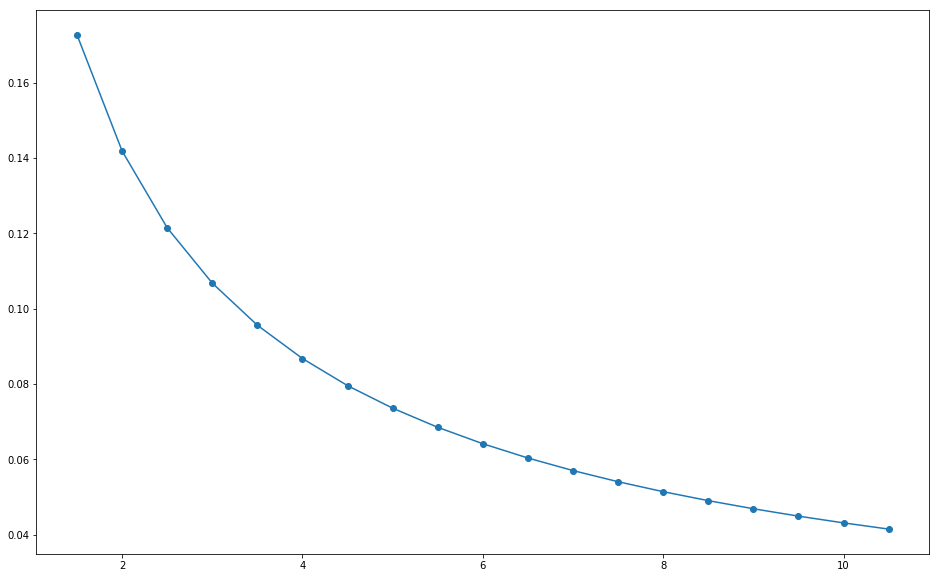

In [91]:
offsets = np.arange(1.5,11.0, 0.5)
errors = []
for x in offsets:
    rmsle = np.sqrt(metrics.mean_squared_log_error(y_test+x, predictions+x))
    errors.append(rmsle)
errors = np.array(errors)

plt.figure(figsize=[16,10])
plt.plot(offsets, errors, 'o-')

### Distributions

In [229]:
spredictions

array([-0.08078796, -0.43090177, -0.6155516 , ...,  0.37530148,
        3.6901767 , -0.22487855], dtype=float32)

In [230]:
bin_width = 0.1
bins=np.arange(-2,12 + bin_width, bin_width)
hist_train, _ = np.histogram(y_train, bins=bins)
hist_test, _ = np.histogram(y_test, bins=bins)
#hist_pred, _ = np.histogram(predictions, bins=bins)
hist_pred, _ = np.histogram(spredictions, bins=bins)

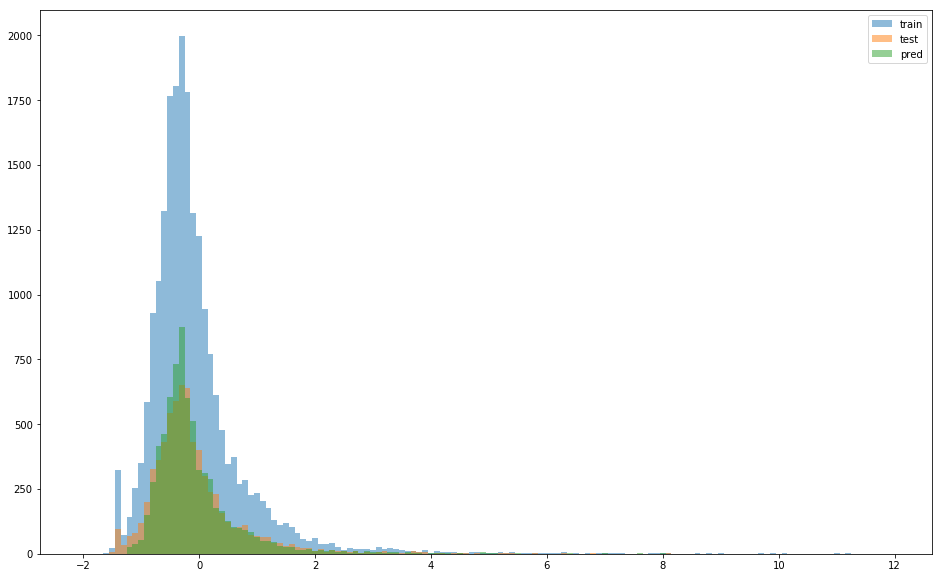

In [231]:
fig, ax = plt.subplots(1,1,figsize=[16,10])

ax.bar( x=bins[:-1],height=hist_train, width=bin_width, label='train', alpha=0.5)
ax.bar( x=bins[:-1],height=hist_test, width=bin_width, label='test', alpha=0.5)
ax.bar( x=bins[:-1],height=hist_pred, width=bin_width, label='pred', alpha=0.5)
ax.legend();

In [232]:
hist_train, _ = np.histogram(y_train, bins=bins, density=True)
hist_test, _ = np.histogram(y_test, bins=bins, density=True)
hist_pred, _ = np.histogram(predictions, bins=bins, density=True)

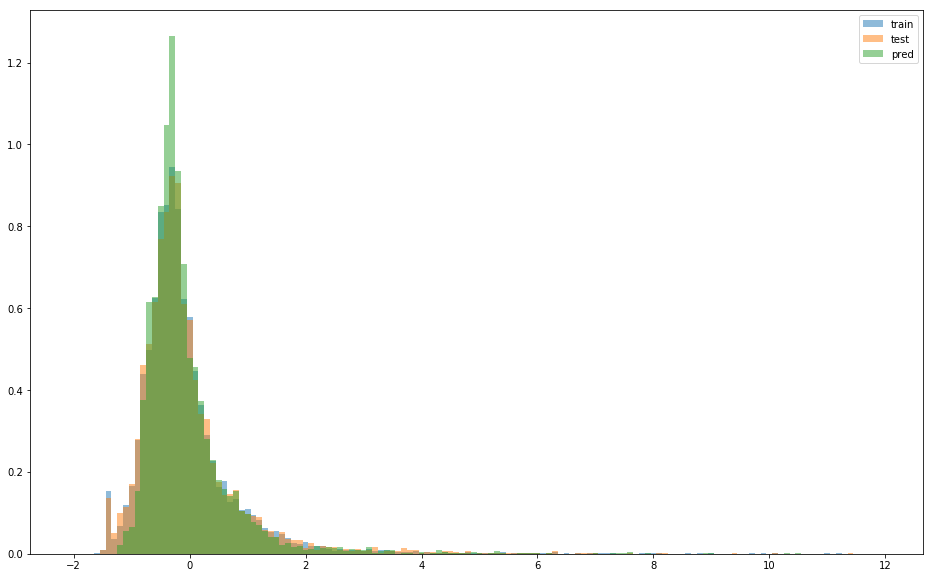

In [233]:
fig, ax = plt.subplots(1,1,figsize=[16,10])

ax.bar( x=bins[:-1],height=hist_train, width=bin_width, label='train', alpha=0.5)
ax.bar( x=bins[:-1],height=hist_test, width=bin_width, label='test', alpha=0.5)
ax.bar( x=bins[:-1],height=hist_pred, width=bin_width, label='pred', alpha=0.5)
ax.legend();

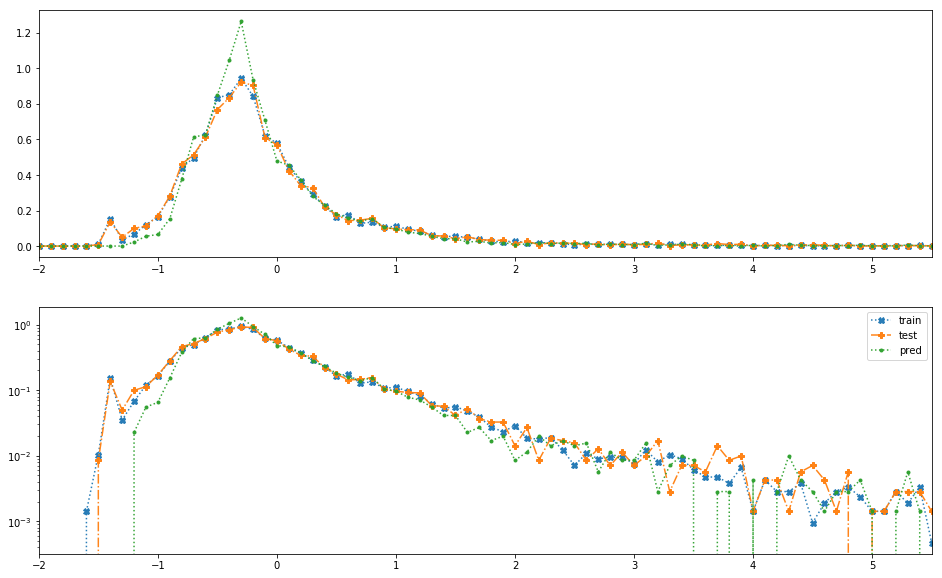

In [234]:
fig, ax = plt.subplots(2,1,figsize=[16,10])

ax =ax.reshape(2)

ax[0].plot( bins[:-1], hist_train, 'X:', label='train', alpha=0.95)
ax[0].plot( bins[:-1], hist_test,  'P-.', label='test',  alpha=0.95)
ax[0].plot( bins[:-1], hist_pred,  '.:', label='pred',  alpha=0.95)
ax[0].set_xlim(-2.0,5.5)

ax[1].plot( bins[:-1], hist_train, 'X:', label='train', alpha=0.95)
ax[1].plot( bins[:-1], hist_test,  'P-.', label='test',  alpha=0.95)
ax[1].plot( bins[:-1], hist_pred,  '.:', label='pred',  alpha=0.95)
ax[1].set_yscale('log')
ax[1].set_xlim(-2.0,5.5)
ax[1].legend();


<hr style="border: solid rgb(255,0,0) 0.0px; background-color: rgb(255,0,0);height: 2.0px;"/>
<font color='red' size=5>
    STOP 
</font>

## Various classifiers

In [92]:
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_log_error, make_scorer
from sklearn.metrics.scorer import neg_mean_squared_error_scorer

from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge, RidgeCV
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import xgboost as xgb
import lightgbm as lgb


classifiers = [
               Ridge(), 
               Lasso(), 
               ElasticNet(),
               KernelRidge(),
               SVR(),
               RandomForestRegressor(),
               GradientBoostingRegressor(),
               lgb.LGBMRegressor(),
               xgb.XGBRegressor(objective="reg:squarederror"),
]

clf_names = [
            "ridge      ",
            "lasso      ",
            "elastic    ",
            "kernlrdg   ",
            "svr        ",
            "rndmforest ", 
            "gbm        ", 
            "lgbm       ", 
            "xgboost    ",
]

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


```
train, test, y_train, y_test = train_test_split(df.drop(["id", "timestamp"], axis=1), 
                                                df_targ.drop(["id","price_doc"], axis=1), random_state=10, test_size=0.25)
model = xgb.XGBRegressor(**xgb_params)
model.fit(X_train,y_train)
predictions = model.predict(X_test)
```

In [93]:
X = df.drop(["id", "timestamp"], axis=1)
y = df_targ.drop(["id","price_doc"], axis=1)
#metric = 'neg_mean_squared_log_error'
metric = 'neg_mean_squared_error'

for clf_name, clf in zip(clf_names, classifiers):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    print(f"{clf_name} {np.sqrt(-cross_val_score(clf, X, y, cv=kfold, scoring=metric)).mean():.4f}")

ridge       0.9728
lasso       0.9996
elastic     0.9996
kernlrdg    0.9728


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

svr         0.5649


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 

rndmforest  0.5334


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

gbm         0.5369
lgbm        0.5239
xgboost     0.5373


In [101]:
from sklearn.metrics import SCORERS
sorted(SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

# Hypertuning the engines

> <span style="color:darkred">Skip ahead to the next chapter (6.) if you don't want to find **new** parameters.

For each of the promising classifiers we now try to find optimal hyperparameters with a search grid and sklearn's `GridSearchCV()`. (*commented out to allow for faster execution of whole kernel*)

As a starting point I looked into several of the kernels that I already have mentioned and tuned based on their findings.


In [96]:
from sklearn.pipeline import Pipeline, make_pipeline

In [67]:
# X = dtrain[dtrain.GrLivArea < 4000].drop(["SalePrice"], axis=1)
# y = np.log1p(dtrain[dtrain.GrLivArea < 4000].SalePrice)
# metric = 'neg_mean_squared_error'

# sk = pd.DataFrame(X.iloc[:, :60].skew(), columns=["skewness"])
# sk = sk[sk.skewness > .75]
# for feature_ in sk.index:
#     X[feature_] = boxcox1p(X[feature_], 0.15)

In [105]:
metric

'neg_mean_squared_error'

In [104]:
# GridSearchCV Ridge
ridge = make_pipeline(Ridge(alpha=15, random_state=1))
#ridge = make_pipeline(RobustScaler(), Ridge(alpha=15, random_state=1))
#ridge = Ridge(alpha=15, random_state=1) # didn't work
param_grid = {
    'ridge__alpha' : np.linspace(1, 10, 1),
}#    'ridge__max_iter' : np.linspace(10, 200, 5),
search = GridSearchCV(ridge, param_grid, cv=kfold, scoring=metric, n_jobs=5)
search.fit(X, y)
print(f"{search.best_params_}")
print(f"{np.sqrt(-search.best_score_):.4}")

{'ridge__alpha': 1.0}
1.065


In [98]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
print(f"{'Ridge'} {np.sqrt(-cross_val_score(Ridge(), X, y, cv=kfold, scoring=metric)).mean():.4f}")

Ridge 0.9728


In [ ]:
Ridge()

In [69]:
# # GridSearchCV Lasso
# lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.00044, random_state=1))
# param_grid = {'lasso__alpha' : np.linspace(0.00005, 0.001, 30)}
# search = GridSearchCV(lasso, param_grid, cv=5, scoring=metric, n_jobs=-1)
# search.fit(X, y)
# print(f"{search.best_params_}")
# print(f"{np.sqrt(-search.best_score_):.4}")

In [70]:
# # GridSearchCV ElasticNet
# elastic = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=1, random_state=1))
# param_grid = {
#     'elasticnet__alpha' : np.linspace(0.0001, 0.001, 10),
#     'elasticnet__l1_ratio' : np.linspace(0.5, 1, 10),
# }
# search = GridSearchCV(elastic, param_grid, cv=5, scoring=metric, n_jobs=-1)
# search.fit(X, y)
# print(f"{search.best_params_}")
# print(f"{np.sqrt(-search.best_score_):.4}")

In [71]:
# # GridSearchCV KernelRidge
# kernel = KernelRidge(alpha=1)
# param_grid = {'alpha' : np.linspace(0.001, 1, 30)}
# search = GridSearchCV(kernel, param_grid, cv=5, scoring=metric, n_jobs=-1)
# search.fit(X, y)
# print(f"{search.best_params_}")
# print(f"{np.sqrt(-search.best_score_):.4}")

In [72]:
# # GridSearchCV GBM
# # huber loss is considered less sensitive to outliers
# gbm = GradientBoostingRegressor(n_estimators=2500, learning_rate=0.04,
#                                    max_depth=2, max_features='sqrt',
#                                    min_samples_leaf=15, min_samples_split=10, 
#                                    loss='huber', random_state=1)
# param_grid = {
#     'n_estimators' : [2500],
#     'learning_rate' : [0.03, 0.04, 0.05],
#     'max_depth' : [2],
# }
# search = GridSearchCV(gbm, param_grid, cv=5, scoring=metric, n_jobs=-1)
# search.fit(X, y)
# print(f"{search.best_params_}")
# print(f"{np.sqrt(-search.best_score_):.4}")

In [73]:
# # GridSearchCV LightGBM
# lgbm = lgb.LGBMRegressor(objective='regression', num_leaves=5,
#                         learning_rate=0.03, n_estimators=8000,
#                         max_bin=55, bagging_fraction=0.8,
#                         bagging_freq=5, feature_fraction=0.23,
#                         feature_fraction_seed=9, bagging_seed=9,
#                         min_data_in_leaf=6, min_sum_hessian_in_leaf=11)
# param_grid = {
#     'n_estimators' : [8000],
#     'learning_rate' : [0.03],
# }
# search = GridSearchCV(clf, param_grid, cv=5, scoring=metric, n_jobs=-1)
# search.fit(X, y)
# print(f"{search.best_params_}")
# print(f"{np.sqrt(-search.best_score_):.4}")

In [75]:
# # try a stacked regressor on top of the seven tuned classifiers 
# # leaving out xgboost in the stack for now since it seems to crash the stacked regressor
# clf_to_stack = [lasso, ridge, elastic, kernel, gbm, lgbm]

# stack = StackingCVRegressor(regressors=(clf_to_stack),
#                             meta_regressor=xgb.XGBRegressor(objective="reg:squarederror", n_jobs=-1), 
#                             use_features_in_secondary=True)

# print(f"{np.sqrt(-cross_val_score(stack, X, y, scoring=metric)).mean():.4f} Log Error")